In [1]:
import os
import re
import pandas as pd
import nilearn as nl
import numpy as np
import seaborn as sns
from nilearn.input_data import NiftiMasker
from nilearn.image.image import mean_img
from nilearn import plotting, image
from nilearn.plotting import view_img
import warnings
warnings.filterwarnings("ignore")
from nilearn.image import math_img
import time
import multiprocessing
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'


/opt/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
project_dir='/data/projects/rf1-mbme-pilot'
subs=pd.read_csv('../derivatives/exclusions.csv')
print("We collected and downloaded data from %s subjects"%(len(subs['sub'].unique())))
GoodSubs=subs.groupby(by='sub').sum()
#print(GoodSubs.columns)
GoodSubs=GoodSubs[
    (GoodSubs['FD_exclusion']<=2)&(
        GoodSubs['ABS_exclusion']<=1)&(
        GoodSubs['Beh_TrialExclusion']<=2)].reset_index()
subs=subs[subs['sub'].isin(GoodSubs['sub'].values)].sort_values(by='sub')
subs.reset_index(inplace=True)

HC=[]
for index, row in subs.iterrows():
    if row['acq'] in ['mb1me4','mb3me4','mb6me4']:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_echo-1_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    else:
        fname='%s/bids/%s/func/%s_task-sharedreward_acq-%s_bold.json'%(project_dir,row['sub'],row['sub'],row['acq'])
    #print(fname)
    f = open(fname)
    data = json.load(f)
    HC.append(data['ReceiveCoilName'])
    f.close()
subs['HeadCoil']=HC
subs['MB'] =  [int(re.search('mb(.*)me',str(x)).group(1)) for x in subs['acq']]
subs['ME'] =  [int(re.search('me(.*)',str(x)).group(1)) for x in subs['acq']]

print(" There are %s number of subjects who passed the exclusion criteria."%(len(subs['sub'].unique())))
print(" %s Were collected using a 64 channel headcoil and %s with a 20 channel headcoil"%(len(subs[subs['HeadCoil']=='HeadNeck_64']['sub'].unique()),
                                                                                          len(subs[subs['HeadCoil']=='HeadNeck_20']['sub'].unique())))
  

We collected and downloaded data from 43 subjects
 There are 32 number of subjects who passed the exclusion criteria.
 19 Were collected using a 64 channel headcoil and 13 with a 20 channel headcoil


# Count Subjects with full L1 output

In [3]:
act=[]
ppi=[]
L2ppi=[]
for index,row in subs.iterrows():
    sub=row['sub']
    acq=row['acq']
    act.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L1_task-sharedreward_model-1_type-ppi_seed-VS_thr5_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,acq)))
    L2ppi.append(os.path.exists(
        project_dir+'/derivatives/fsl/%s/L2_task-sharedreward_model-1_type-ppi_seed-VS_thr5_sm-4.gfeat/cope10.feat/stats/cope1.nii.gz'%(sub)))

subs['L1act']=act
subs['L1ppi']=ppi
subs['L2ppi']=L2ppi
#display(subs)
subs[subs['L2ppi']==False].head()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi


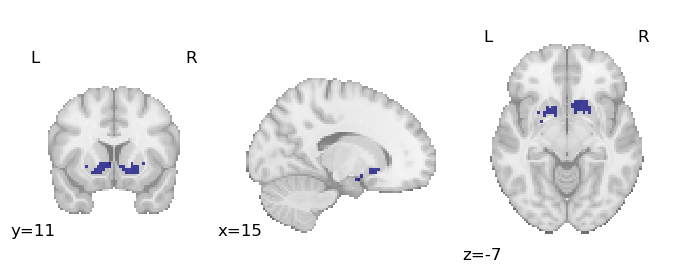

In [4]:
r_vs='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
l_vs='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
F_VS=math_img('img1+img2',img1=r_vs,img2=l_vs)
plotting.plot_roi(F_VS,draw_cross=False)
plt.savefig("../derivatives/figures/assets/mask_VS-func.svg")
plt.show()

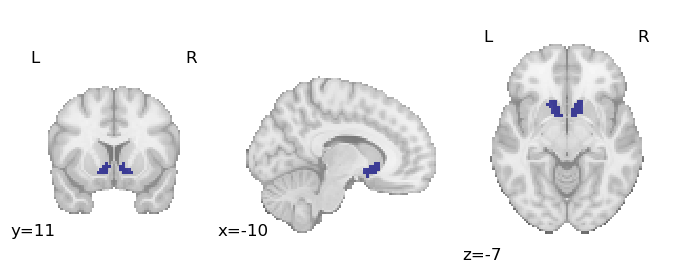

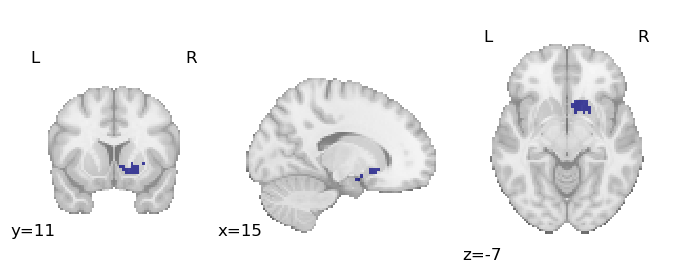

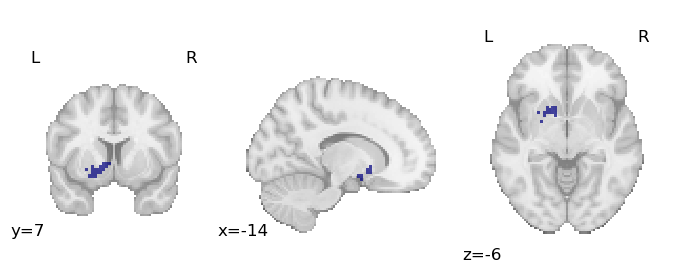

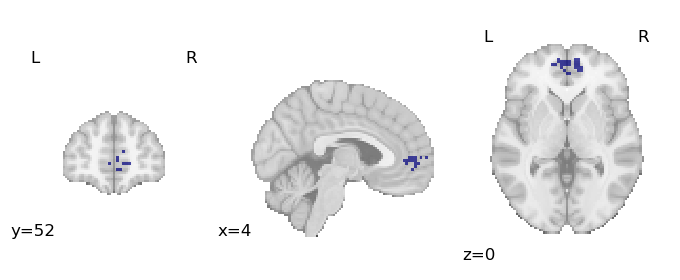

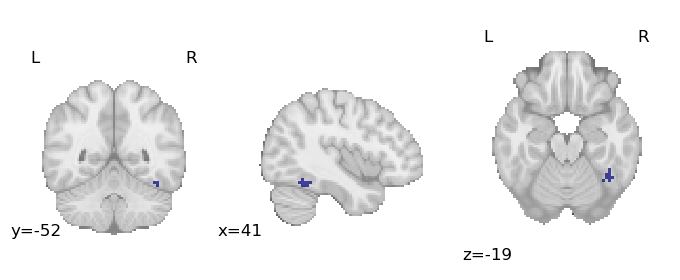

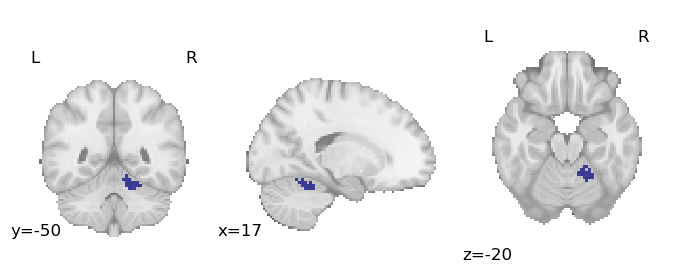

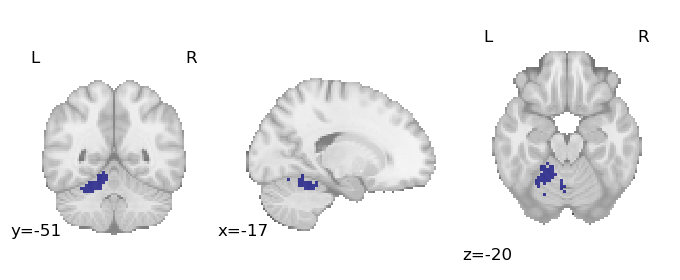

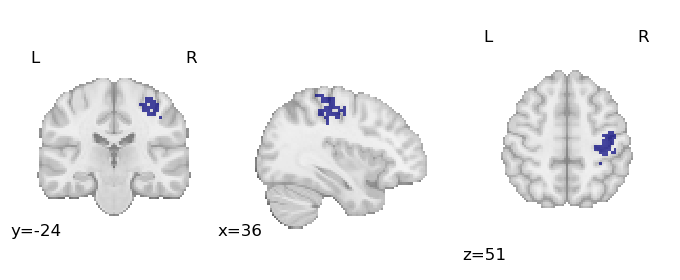

In [19]:
from nilearn import  image
#Striatum Mask
if 1==1:
    VS_mask='../masks/ROI-VS_cname-prereg.nii.gz'
    rstr_mask='../masks/fROI-RVS_cname-RewVsPun_zstat-1.nii.gz'
    lstr_mask='../masks/fROI-LVS_cname-RewVsPun_zstat-1.nii.gz'
    pfc_mask='../masks/fROI-vmPFC_cname-RewVsPun_zstat-1.nii.gz'
    FFA_mask='../masks/FFA_voxel-thresh-mask.nii.gz'
    sCerb_mask='../masks/right-cerb_voxel-thresh.nii.gz'
    iCerb_mask='../masks/left-cerb_voxel-thresh.nii.gz'
    motor_mask='../masks/right-motor_voxel-thresh.nii.gz'
    mask_list=[VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]
    
    for mask in mask_list:
        str_mask=NiftiMasker(mask_img=mask)
        #mask_name=re.search('ROI-(.*)_cname',mask).group(1)
        #print(mask_name)
        mask_name='unknown'
        plotting.plot_roi(mask,draw_cross=False)
        plt.savefig("../derivatives/figures/assets/mask_%s.svg"%(mask_name))
        plt.show()
mask_list=[F_VS,VS_mask,rstr_mask,lstr_mask,pfc_mask,FFA_mask,sCerb_mask,iCerb_mask,motor_mask]


# VS- Reward Activiation

In [6]:
#masker= NiftiMasker(mask_img=VS_mask)
masker= NiftiMasker(mask_img=F_VS)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope13.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat13.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope13.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(VS_Reward_cope=copes,
               VS_Reward_zstats=zstats,
               VS_Reward_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████| 190/190 [02:56<00:00,  1.08it/s]


# Display Reward Activation by Acquisition

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: VS_Reward_zstats
No. Observations: 114     Method:             REML            
No. Groups:       19      Scale:              0.2531          
Min. group size:  6       Log-Likelihood:     -92.2474        
Max. group size:  6       Converged:          Yes             
Mean group size:  6.0                                         
----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------
Intercept    0.182      0.175    1.042   0.297   -0.160    0.524
MB           0.093      0.045    2.081   0.037    0.005    0.180
ME           0.023      0.060    0.392   0.695   -0.094    0.141
MB:ME       -0.016      0.015   -1.069   0.285   -0.046    0.014
Group Var    0.000      0.034                                   
==============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: VS_Reward_cope
No. Observations: 114     Method:             REML          
No. Groups:       19      Scale:              27998.7534    
Min. group size:  6       Log-Likelihood:     -731.0023     
Max. group size:  6       Converged:          Yes           
Mean group size:  6.0                                       
-------------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
-------------------------------------------------------------
Intercept   91.767    58.047   1.581  0.114  -22.004  205.538
MB          11.486    14.824   0.775  0.438  -17.568   40.541
ME          15.623    19.910   0.785  0.433  -23.400   54.646
MB:ME       -4.246     5.085  -0.835  0.404  -14.212    5.719
Group Var    0.006    10.304                                 
============================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: VS_Reward_zstats
No. Observations: 69      Method:             REML            
No. Groups:       12      Scale:              0.1656          
Min. group size:  5       Log-Likelihood:     -47.2808        
Max. group size:  6       Converged:          Yes             
Mean group size:  5.8                                         
----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
----------------------------------------------------------------
Intercept   -0.054      0.188   -0.289   0.772   -0.422    0.314
MB           0.073      0.046    1.582   0.114   -0.018    0.164
ME           0.083      0.062    1.331   0.183   -0.039    0.205
MB:ME       -0.021      0.016   -1.311   0.190   -0.052    0.010
Group Var    0.019      0.055                                   
==============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: VS_Reward_cope
No. Observations: 69      Method:             REML          
No. Groups:       12      Scale:              26679.7599    
Min. group size:  5       Log-Likelihood:     -437.8411     
Max. group size:  6       Converged:          Yes           
Mean group size:  5.8                                       
------------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------
Intercept     -14.690   76.177 -0.193 0.847 -163.995 134.616
MB             21.418   18.590  1.152 0.249  -15.017  57.853
ME             39.619   25.036  1.582 0.114   -9.451  88.690
MB:ME          -7.726    6.397 -1.208 0.227  -20.264   4.812
Group Var    4408.739   26.098                              
============================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM    Dependent Variable:    VS_Reward_zstats
No. Observations:     183        Method:                REML            
No. Groups:           31         Scale:                 0.2238          
Min. group size:      5          Log-Likelihood:        -141.1378       
Max. group size:      6          Converged:             Yes             
Mean group size:      5.9                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.056    0.214 -0.261 0.794 -0.475  0.363
HeadCoil[T.HeadNeck_64]        0.238    0.270  0.881 0.378 -0.291  0.767
MB                             0.073    0.054  1.360 0.174 -0.032  0.179
MB:HeadCoil[T.HeadNeck_64]     0.020    0.068  0.288 0.773 -0.114  0.153
ME                             0.083    0.072  1.141 0.254 -0.059  0.225
ME:HeadCoil[T.HeadNeck_64]    -0.059    0.092 -0.645 0.519 -0.239  0.121
MB:ME                         -0.020    0.018 -1.103 0.270 -0.057  0.016
MB:ME:HeadCoil[T.HeadNeck_64]  0.004    0.023  0.173 0.862 -0.042  0.050
Group Var                      0.004    0.025                           
========================================================================

"""

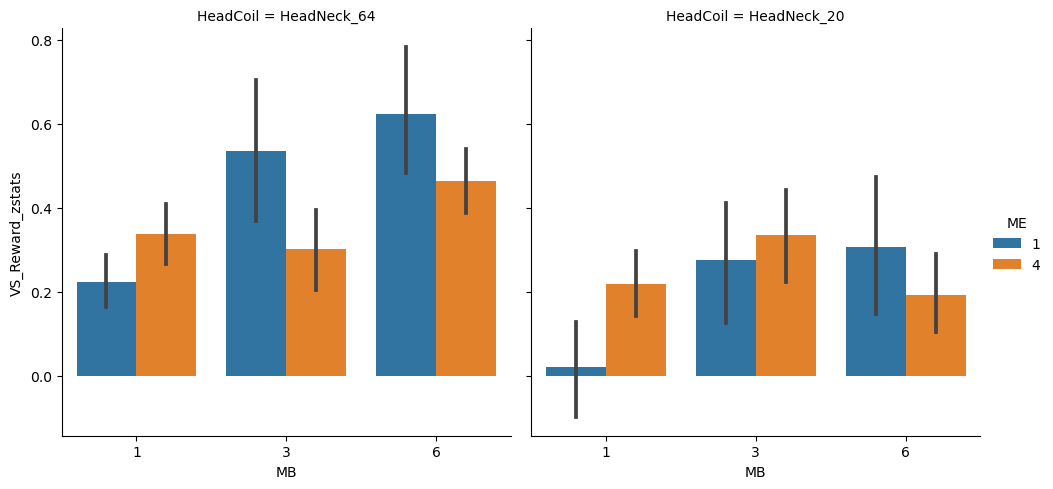

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                   MixedLM      Dependent Variable:      VS_Reward_cope
No. Observations:        183          Method:                  REML          
No. Groups:              31           Scale:                   27593.6517    
Min. group size:         5            Log-Likelihood:          -1169.5912    
Max. group size:         6            Converged:               Yes           
Mean group size:         5.9                                                 
-----------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                      -15.630   75.724 -0.206 0.836 -164.047 132.786
HeadCoil[T.HeadNeck_64]        107.398   95.581  1.124 0.261  -79.938 294.733
MB                              21.438   18.890  1.135 0.256  -15.585  58.461
MB:HeadCoil[T.HeadNeck_64]      -9.952   23.946 -0.416 0.678  -56.884  36.981
ME                              39.518   25.437  1.554 0.120  -10.337  89.373
ME:HeadCoil[T.HeadNeck_64]     -23.895   32.213 -0.742 0.458  -87.032  39.242
MB:ME                           -7.543    6.499 -1.161 0.246  -20.281   5.195
MB:ME:HeadCoil[T.HeadNeck_64]    3.297    8.229  0.401 0.689  -12.831  19.426
Group Var                     1536.464   10.846                              
=============================================================================

"""

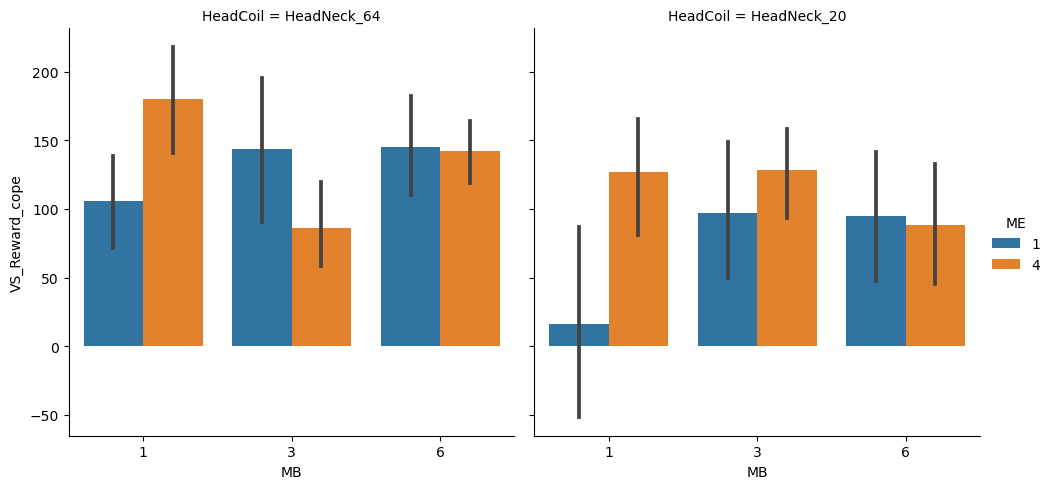

In [7]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('VS_Reward_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('VS_Reward_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('VS_Reward_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())

sns.catplot(x='MB',y='VS_Reward_zstats',hue='ME',data=plt_df,kind='bar',ci=68,
            order=[1,3,6],col='HeadCoil')

plt.savefig("../derivatives/figures/assets/Reward_VS-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('VS_Reward_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='VS_Reward_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.savefig("../derivatives/figures/assets/Reward_VS-act_cope.svg")

plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('VS_Reward_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='VS_Reward_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.savefig("../derivatives/figures/assets/Reward_VS-act_varcope.svg")
#plt.show()

,index,sub,acq,TrialCount_misses,Max_Abs_motion,FD_mean,FD_exclusion,ABS_exclusion,Beh_TrialExclusion,HeadCoil,MB,ME,L1act,L1ppi,L2ppi,VS_Reward_cope,VS_Reward_zstats,VS_Reward_varcope
0,180,sub-10017,mb3me1,0,0.627543,0.119987,False,False,False,HeadNeck_64,3,1,True,True,True,309.407959,1.249983,76801.156250
1,181,sub-10017,mb6me4,1,0.680831,0.086961,False,False,False,HeadNeck_64,6,4,True,True,True,136.362366,0.421408,88522.718750
2,178,sub-10017,mb1me1,0,0.786339,0.102325,False,False,False,HeadNeck_64,1,1,True,True,True,70.116760,0.230986,287302.875000
3,179,sub-10017,mb3me4,0,0.560430,0.095748,False,False,False,HeadNeck_64,3,4,True,True,True,63.179405,0.243662,96206.695312
4,182,sub-10017,mb1me4,0,0.403440,0.075867,False,False,False,HeadNeck_64,1,4,True,True,True,80.045624,0.253255,209722.671875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,32,sub-12042,mb3me1,0,0.882717,0.166905,False,False,False,HeadNeck_20,3,1,True,True,True,119.178452,0.348129,139635.312500
186,33,sub-12042,mb6me4,0,0.465247,0.086336,False,False,False,HeadNeck_20,6,4,True,True,True,178.331131,0.463051,192740.109375
187,34,sub-12042,mb1me4,0,0.384643,0.091856,False,False,False,HeadNeck_20,1,4,True,True,True,188.691574,0.384150,383343.500000
188,35,sub-12042,mb6me1,0,0.562190,0.120174,False,False,False,HeadNeck_20,6,1,True,True,True,54.769428,0.104857,99543.578125


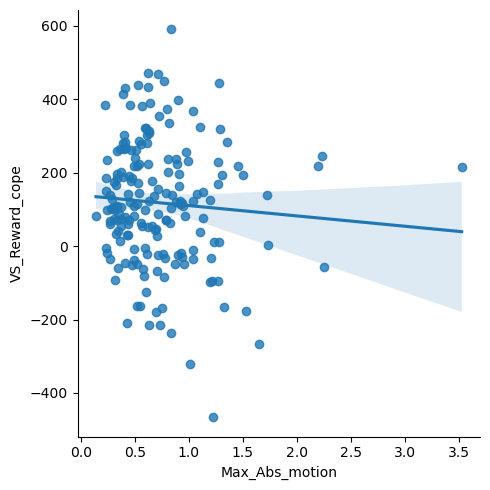

In [8]:
display(plt_df)
sns.lmplot(x='Max_Abs_motion',y='VS_Reward_cope',data=plt_df)

# FFA-Face Activiation

In [9]:
masker= NiftiMasker(mask_img=FFA_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope11.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat11.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope11.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(FFA_face_cope=copes,
               FFA_face_zstats=zstats,
               FFA_face_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████| 190/190 [03:07<00:00,  1.01it/s]


# Display Face Activation by Acquisition (FFA)

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_face_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.5271         
Min. group size:  6       Log-Likelihood:     -139.5000      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.418     0.262   1.595  0.111  -0.096   0.932
MB              0.088     0.064   1.369  0.171  -0.038   0.214
ME              0.035     0.086   0.400  0.689  -0.135   0.204
MB:ME          -0.002     0.022  -0.097  0.923  -0.045   0.041
Group Var       0.102     0.095                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_face_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              45306.5955   
Min. group size:  6       Log-Likelihood:     -762.6074    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     179.307   75.882  2.363 0.018  30.581 328.033
MB             -6.602   18.857 -0.350 0.726 -43.561  30.358
ME              1.712   25.327  0.068 0.946 -47.928  51.352
MB:ME           3.012    6.468  0.466 0.641  -9.665  15.689
Group Var    5807.307   22.875                             
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: FFA_face_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.7170         
Min. group size:  5       Log-Likelihood:     -95.9305       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.679     0.396   1.717  0.086  -0.096   1.455
MB              0.029     0.096   0.299  0.765  -0.160   0.218
ME             -0.032     0.130  -0.247  0.805  -0.286   0.222
MB:ME          -0.022     0.033  -0.649  0.516  -0.087   0.043
Group Var       0.124     0.136                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: FFA_face_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              101334.9522  
Min. group size:  5       Log-Likelihood:     -480.5151    
Max. group size:  6       Converged:          No           
Mean group size:  5.8                                      
-----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------
Intercept    259.252  147.244  1.761 0.078  -29.341 547.845
MB             1.621   36.221  0.045 0.964  -69.371  72.613
ME           -17.430   48.786 -0.357 0.721 -113.049  78.189
MB:ME         -8.054   12.459 -0.646 0.518  -32.474  16.366
Group Var  12637.310   49.540                              
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    FFA_face_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.5975         
Min. group size:       5          Log-Likelihood:        -236.3663      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.680    0.362  1.879 0.060 -0.029  1.389
HeadCoil[T.HeadNeck_64]       -0.262    0.457 -0.573 0.567 -1.157  0.634
MB                             0.029    0.088  0.327 0.744 -0.144  0.201
MB:HeadCoil[T.HeadNeck_64]     0.059    0.111  0.532 0.595 -0.159  0.278
ME                            -0.032    0.119 -0.272 0.786 -0.264  0.200
ME:HeadCoil[T.HeadNeck_64]     0.067    0.150  0.445 0.656 -0.227  0.361
MB:ME                         -0.022    0.030 -0.711 0.477 -0.081  0.038
MB:ME:HeadCoil[T.HeadNeck_64]  0.019    0.038  0.506 0.613 -0.056  0.094
Group Var                      0.110    0.078                           
========================================================================

"""

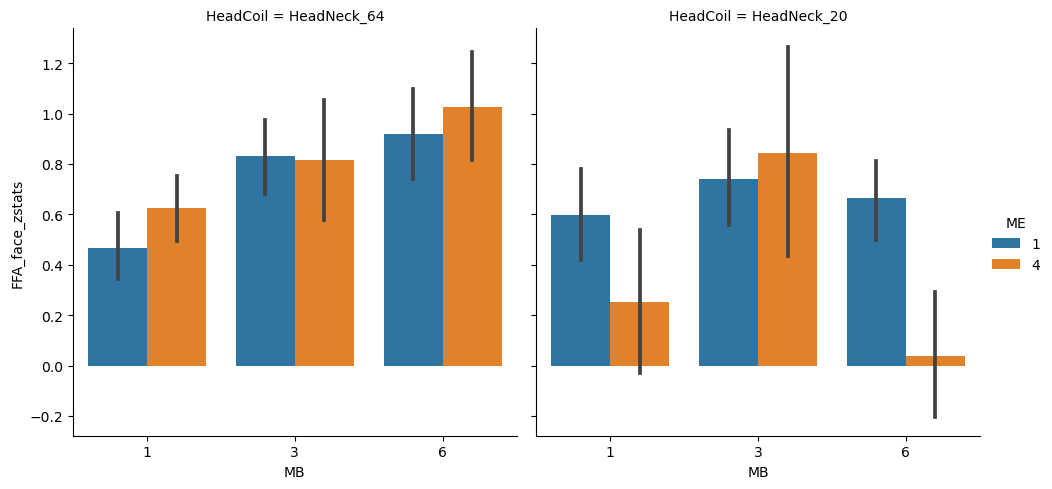

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                  MixedLM       Dependent Variable:       FFA_face_cope
No. Observations:       183           Method:                   REML         
No. Groups:             31            Scale:                    69560.8026   
Min. group size:        5             Log-Likelihood:           -1250.2603   
Max. group size:        6             Converged:                Yes          
Mean group size:        5.9                                                  
-----------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                      258.361  120.131  2.151 0.032   22.908 493.814
HeadCoil[T.HeadNeck_64]        -79.054  151.636 -0.521 0.602 -376.255 218.146
MB                               1.746   29.991  0.058 0.954  -57.036  60.527
MB:HeadCoil[T.HeadNeck_64]      -8.347   38.019 -0.220 0.826  -82.862  66.168
ME                             -16.937   40.387 -0.419 0.675  -96.095  62.220
ME:HeadCoil[T.HeadNeck_64]      18.649   51.147  0.365 0.715  -81.596 118.895
MB:ME                           -8.101   10.316 -0.785 0.432  -28.319  12.117
MB:ME:HeadCoil[T.HeadNeck_64]   11.113   13.063  0.851 0.395  -14.490  36.716
Group Var                     3621.612   14.216                              
=============================================================================

"""

<Figure size 640x480 with 0 Axes>

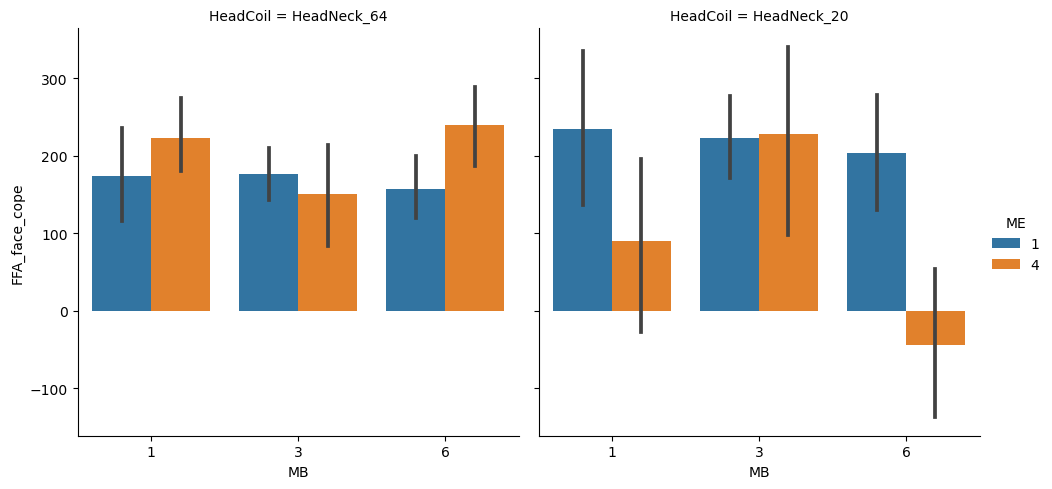

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('FFA_face_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('FFA_face_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('FFA_face_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('FFA_face_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='FFA_face_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('FFA_face_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='FFA_face_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/FFA_face-act_varcope.svg")


# Central Gyrus-Button Activiation

In [20]:
masker= NiftiMasker(mask_img=motor_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(Motor_LR_cope=copes,
               Motor_LR_zstats=zstats,
               Motor_LR_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████| 190/190 [02:32<00:00,  1.25it/s]


# Display Motor Activation by Acquisition

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.4479         
Min. group size:  6       Log-Likelihood:     -141.7939      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.582     0.282   2.065  0.039   0.030   1.135
MB              0.213     0.059   3.598  0.000   0.097   0.330
ME              0.070     0.080   0.881  0.378  -0.086   0.226
MB:ME          -0.020     0.020  -0.992  0.321  -0.060   0.020
Group Var       0.487     0.306                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              23594.6195   
Min. group size:  6       Log-Likelihood:     -736.4367    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     175.960   60.909  2.889 0.004  56.581 295.339
MB             15.719   13.608  1.155 0.248 -10.953  42.391
ME             31.172   18.277  1.706 0.088  -4.650  66.995
MB:ME          -4.783    4.668 -1.025 0.306 -13.931   4.366
Group Var   16537.366   48.572                             
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: Motor_LR_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.4646         
Min. group size:  5       Log-Likelihood:     -88.0302       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.718     0.360   1.991  0.047   0.011   1.424
MB              0.201     0.078   2.591  0.010   0.049   0.353
ME              0.136     0.105   1.302  0.193  -0.069   0.341
MB:ME          -0.039     0.027  -1.465  0.143  -0.092   0.013
Group Var       0.419     0.341                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: Motor_LR_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              68702.0068   
Min. group size:  5       Log-Likelihood:     -474.1215    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     393.466  135.589  2.902 0.004 127.717 659.215
MB              7.184   29.868  0.241 0.810 -51.357  65.725
ME             24.039   40.242  0.597 0.550 -54.835 102.913
MB:ME          -2.196   10.278 -0.214 0.831 -22.340  17.948
Group Var   51982.817  114.234                             
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    Motor_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.4541         
Min. group size:       5          Log-Likelihood:        -229.8611      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.718    0.362  1.982 0.047  0.008  1.429
HeadCoil[T.HeadNeck_64]       -0.136    0.459 -0.296 0.767 -1.035  0.763
MB                             0.201    0.077  2.619 0.009  0.051  0.352
MB:HeadCoil[T.HeadNeck_64]     0.012    0.097  0.125 0.900 -0.178  0.203
ME                             0.136    0.103  1.314 0.189 -0.067  0.339
ME:HeadCoil[T.HeadNeck_64]    -0.066    0.131 -0.503 0.615 -0.322  0.191
MB:ME                         -0.039    0.026 -1.480 0.139 -0.091  0.013
MB:ME:HeadCoil[T.HeadNeck_64]  0.019    0.033  0.566 0.571 -0.047  0.084
Group Var                      0.461    0.229                           
========================================================================

"""

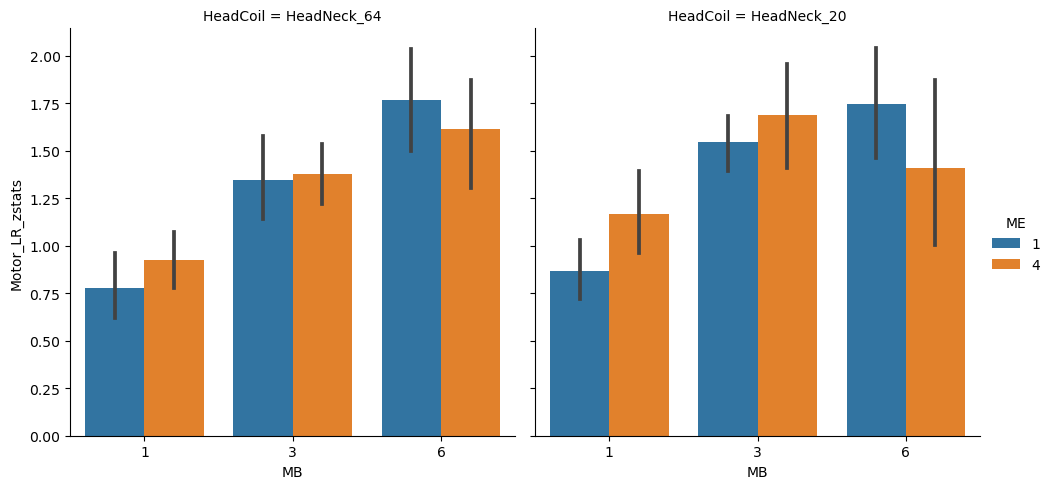

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM       Dependent Variable:       Motor_LR_cope
No. Observations:        183           Method:                   REML         
No. Groups:              31            Scale:                    40298.6234   
Min. group size:         5             Log-Likelihood:           -1223.0119   
Max. group size:         6             Converged:                Yes          
Mean group size:         5.9                                                  
------------------------------------------------------------------------------
                                Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------
Intercept                       393.415  103.624  3.797 0.000  190.316 596.515
HeadCoil[T.HeadNeck_64]        -217.456  131.012 -1.660 0.097 -474.235  39.323
MB                                7.197   22.875  0.315 0.753  -37.637  52.030
MB:HeadCoil[T.HeadNeck_64]        8.522   28.975  0.294 0.769  -48.267  65.312
ME                               24.066   30.818  0.781 0.435  -36.336  84.468
ME:HeadCoil[T.HeadNeck_64]        7.106   38.991  0.182 0.855  -69.315  83.527
MB:ME                            -2.204    7.871 -0.280 0.779  -17.630  13.222
MB:ME:HeadCoil[T.HeadNeck_64]    -2.579    9.958 -0.259 0.796  -22.096  16.938
Group Var                     29952.868   52.857                              
==============================================================================

"""

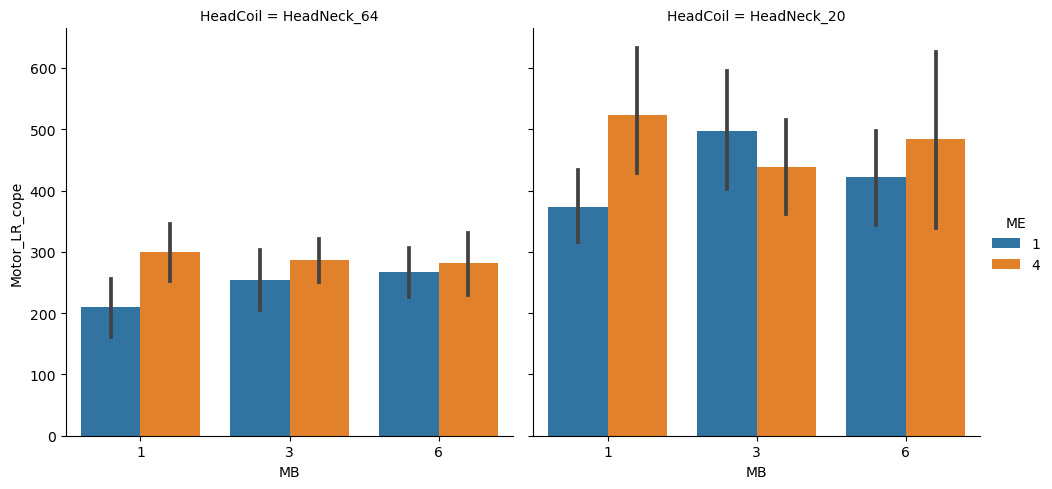

In [21]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('Motor_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('Motor_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('Motor_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/Motor_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('Motor_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='Motor_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/Motor_LR-act_cope.svg")
plt.show()


# print("Results for VarCope")
# res=smf.mixedlm('Motor_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='Motor_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

#plt.savefig("../derivatives/figures/assets/Motor_LR-act_varcope.svg")
#plt.show()

# Central ICerbt-Button Activiation

In [13]:
masker= NiftiMasker(mask_img=iCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(iCerb_LR_cope=copes,
               iCerb_LR_zstats=zstats,
               iCerb_LR_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████| 190/190 [02:34<00:00,  1.23it/s]


# Display Inferior Cerebellar Activation by Acquisition

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: iCerb_LR_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.2671         
Min. group size:  6       Log-Likelihood:     -111.3072      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.263     0.209   1.257  0.209  -0.147   0.674
MB              0.179     0.046   3.913  0.000   0.089   0.269
ME              0.073     0.061   1.187  0.235  -0.048   0.194
MB:ME          -0.025     0.016  -1.598  0.110  -0.056   0.006
Group Var       0.222     0.188                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: iCerb_LR_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              39051.2549   
Min. group size:  6       Log-Likelihood:     -763.6193    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     185.411   77.706  2.386 0.017  33.109 337.713
MB             15.343   17.507  0.876 0.381 -18.970  49.656
ME             14.694   23.514  0.625 0.532 -31.392  60.780
MB:ME          -3.951    6.005 -0.658 0.511 -15.721   7.818
Group Var   25435.028   58.918                             
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: iCerb_LR_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.3154         
Min. group size:  5       Log-Likelihood:     -70.1845       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.219     0.266   0.824  0.410  -0.302   0.740
MB              0.140     0.064   2.186  0.029   0.014   0.265
ME              0.094     0.086   1.093  0.274  -0.075   0.263
MB:ME          -0.026     0.022  -1.163  0.245  -0.069   0.018
Group Var       0.075     0.106                               
=============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: iCerb_LR_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              45448.1711   
Min. group size:  5       Log-Likelihood:     -453.7449    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     262.641   97.865  2.684 0.007  70.828 454.454
MB             -6.430   24.250 -0.265 0.791 -53.960  41.099
ME            -12.107   32.658 -0.371 0.711 -76.115  51.902
MB:ME           6.403    8.343  0.768 0.443  -9.948  22.755
Group Var    4019.861   25.433                             
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    iCerb_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.2852         
Min. group size:       5          Log-Likelihood:        -182.5856      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.218    0.269  0.812 0.417 -0.308  0.745
HeadCoil[T.HeadNeck_64]        0.045    0.339  0.133 0.894 -0.620  0.710
MB                             0.140    0.061  2.302 0.021  0.021  0.259
MB:HeadCoil[T.HeadNeck_64]     0.039    0.077  0.508 0.612 -0.112  0.190
ME                             0.094    0.082  1.148 0.251 -0.067  0.255
ME:HeadCoil[T.HeadNeck_64]    -0.021    0.104 -0.203 0.839 -0.224  0.182
MB:ME                         -0.026    0.021 -1.225 0.220 -0.067  0.015
MB:ME:HeadCoil[T.HeadNeck_64]  0.001    0.026  0.021 0.983 -0.051  0.052
Group Var                      0.166    0.115                           
========================================================================

"""

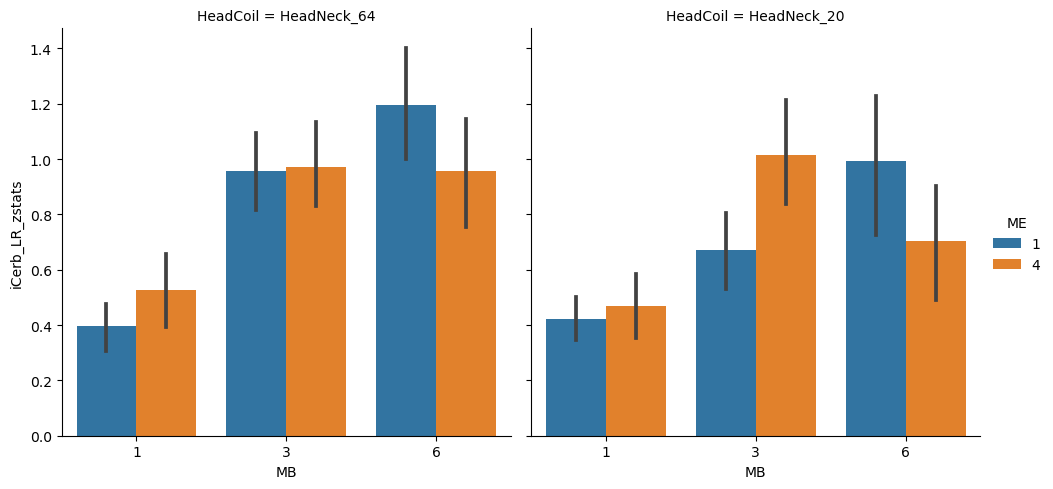

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM       Dependent Variable:       iCerb_LR_cope
No. Observations:        183           Method:                   REML         
No. Groups:              31            Scale:                    41378.4041   
Min. group size:         5             Log-Likelihood:           -1219.0480   
Max. group size:         6             Converged:                Yes          
Mean group size:         5.9                                                  
------------------------------------------------------------------------------
                                Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------
Intercept                       261.651   99.537  2.629 0.009   66.563 456.739
HeadCoil[T.HeadNeck_64]         -76.239  125.726 -0.606 0.544 -322.658 170.180
MB                               -6.364   23.169 -0.275 0.784  -51.774  39.046
MB:HeadCoil[T.HeadNeck_64]       21.707   29.352  0.740 0.460  -35.822  79.237
ME                              -12.468   31.209 -0.399 0.690  -73.636  48.701
ME:HeadCoil[T.HeadNeck_64]       27.161   39.495  0.688 0.492  -50.247 104.570
MB:ME                             6.600    7.971  0.828 0.408   -9.022  22.222
MB:ME:HeadCoil[T.HeadNeck_64]   -10.551   10.086 -1.046 0.296  -30.320   9.218
Group Var                     17478.060   34.483                              
==============================================================================

"""

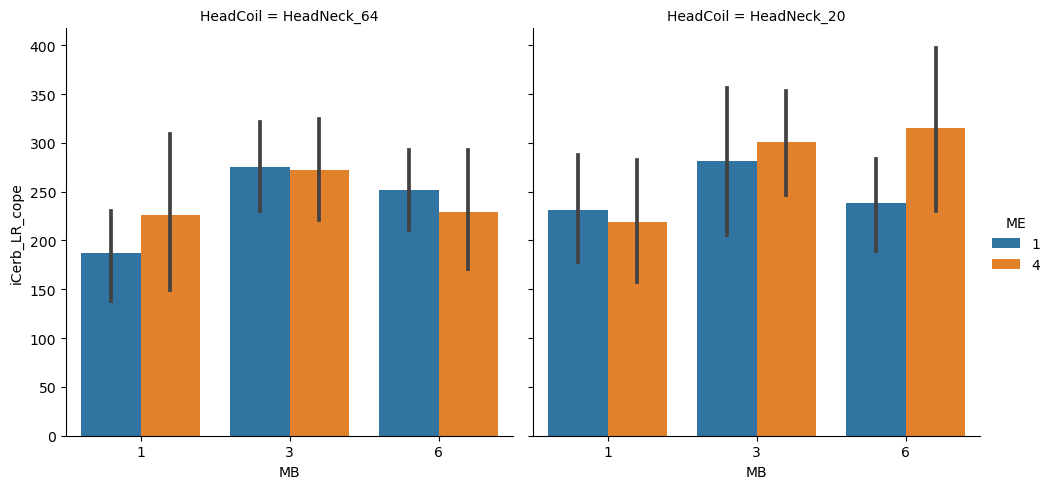

<Figure size 640x480 with 0 Axes>

In [14]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('iCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('iCerb_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('iCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='iCerb_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_cope.svg")
plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('iCerb_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='iCerb_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/iCerb_LR-act_varcope.svg")
plt.show()

# SCerb-Button Activiation

In [15]:
masker= NiftiMasker(mask_img=sCerb_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope12.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/zstat12.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope12.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(SCerb_LR_cope=copes,
               SCerb_LR_zstats=zstats,
               SCerb_LR_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████| 190/190 [02:47<00:00,  1.13it/s]


# Display Superior Cerebellar Activation by Acquisition

HeadNeck_64
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: SCerb_LR_zstats
No. Observations: 114     Method:             REML           
No. Groups:       19      Scale:              0.2691         
Min. group size:  6       Log-Likelihood:     -108.0307      
Max. group size:  6       Converged:          Yes            
Mean group size:  6.0                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.534     0.199  -2.689  0.007  -0.923  -0.145
MB             -0.073     0.046  -1.587  0.113  -0.163   0.017
ME              0.020     0.062   0.328  0.743  -0.101   0.141
MB:ME          -0.010     0.016  -0.648  0.517  -0.041   0.021
Group Var       0.133     0.125                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: SCerb_LR_cope
No. Observations: 114     Method:             REML         
No. Groups:       19      Scale:              41927.5257   
Min. group size:  6       Log-Likelihood:     -760.2982    
Max. group size:  6       Converged:          Yes          
Mean group size:  6.0                                      
-----------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------
Intercept  -293.365   74.070 -3.961 0.000 -438.540 -148.191
MB           18.676   18.140  1.030 0.303  -16.878   54.231
ME           32.534   24.364  1.335 0.182  -15.219   80.287
MB:ME       -12.020    6.222 -1.932 0.053  -24.215    0.175
Group Var  8371.527   27.341                               
===========================================================

"""

HeadNeck_20
z-stat


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:            MixedLM Dependent Variable: SCerb_LR_zstats
No. Observations: 69      Method:             REML           
No. Groups:       12      Scale:              0.2273         
Min. group size:  5       Log-Likelihood:     -62.3135       
Max. group size:  6       Converged:          Yes            
Mean group size:  5.8                                        
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept      -0.432     0.237  -1.823  0.068  -0.896   0.032
MB             -0.053     0.054  -0.980  0.327  -0.160   0.053
ME             -0.010     0.073  -0.142  0.887  -0.154   0.133
MB:ME           0.002     0.019   0.092  0.926  -0.035   0.038
Group Var       0.116     0.151                               
=============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:            MixedLM Dependent Variable: SCerb_LR_cope
No. Observations: 69      Method:             REML         
No. Groups:       12      Scale:              40932.1620   
Min. group size:  5       Log-Likelihood:     -455.0999    
Max. group size:  6       Converged:          Yes          
Mean group size:  5.8                                      
-----------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    -161.414   99.491 -1.622 0.105 -356.413 33.584
MB             -6.599   23.046 -0.286 0.775  -51.769 38.570
ME            -10.884   31.045 -0.351 0.726  -71.731 49.962
MB:ME          -1.529    7.929 -0.193 0.847  -17.070 14.012
Group Var   18437.938   58.540                             
===========================================================

"""

Results for Zstatistics


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                 MixedLM    Dependent Variable:    SCerb_LR_zstats
No. Observations:      183        Method:                REML           
No. Groups:            31         Scale:                 0.2536         
Min. group size:       5          Log-Likelihood:        -170.6196      
Max. group size:       6          Converged:             Yes            
Mean group size:       5.9                                              
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.432    0.250 -1.729 0.084 -0.921  0.058
HeadCoil[T.HeadNeck_64]       -0.102    0.316 -0.323 0.746 -0.721  0.516
MB                            -0.053    0.057 -0.928 0.354 -0.166  0.059
MB:HeadCoil[T.HeadNeck_64]    -0.020    0.073 -0.271 0.786 -0.162  0.123
ME                            -0.010    0.077 -0.135 0.892 -0.162  0.141
ME:HeadCoil[T.HeadNeck_64]     0.031    0.098  0.314 0.753 -0.161  0.222
MB:ME                          0.002    0.020  0.088 0.930 -0.037  0.040
MB:ME:HeadCoil[T.HeadNeck_64] -0.012    0.025 -0.479 0.632 -0.061  0.037
Group Var                      0.127    0.097                           
========================================================================

"""

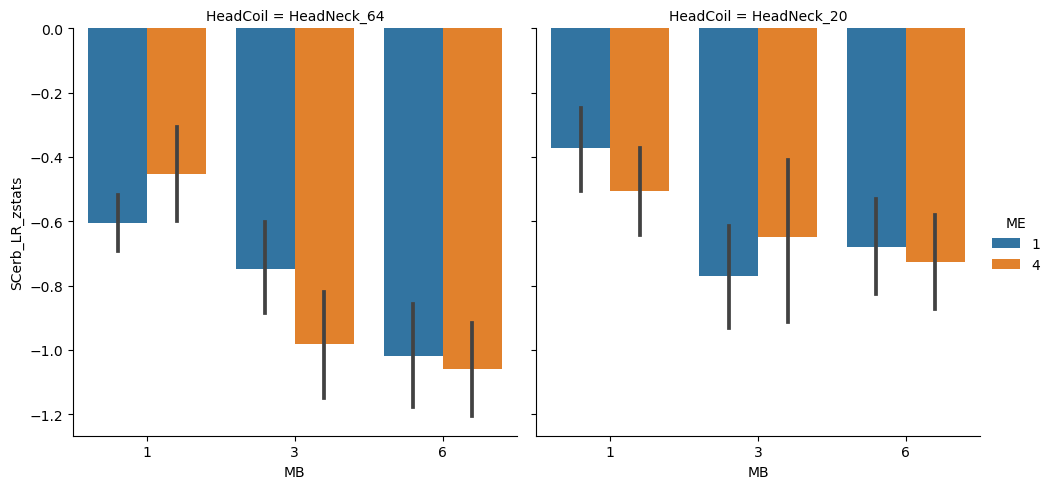

Results for Cope


<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
==============================================================================
Model:                   MixedLM       Dependent Variable:       SCerb_LR_cope
No. Observations:        183           Method:                   REML         
No. Groups:              31            Scale:                    41554.2969   
Min. group size:         5             Log-Likelihood:           -1215.8363   
Max. group size:         6             Converged:                Yes          
Mean group size:         5.9                                                  
------------------------------------------------------------------------------
                                Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
------------------------------------------------------------------------------
Intercept                      -160.789   97.431 -1.650 0.099 -351.749  30.172
HeadCoil[T.HeadNeck_64]        -132.577  123.020 -1.078 0.281 -373.691 108.537
MB                               -6.769   23.212 -0.292 0.771  -52.264  38.726
MB:HeadCoil[T.HeadNeck_64]       25.445   29.410  0.865 0.387  -32.197  83.087
ME                              -11.187   31.266 -0.358 0.720  -72.467  50.093
ME:HeadCoil[T.HeadNeck_64]       43.721   39.571  1.105 0.269  -33.838 121.279
MB:ME                            -1.423    7.986 -0.178 0.859  -17.074  14.229
MB:ME:HeadCoil[T.HeadNeck_64]   -10.597   10.106 -1.049 0.294  -30.405   9.211
Group Var                     12164.585   26.975                              
==============================================================================

"""

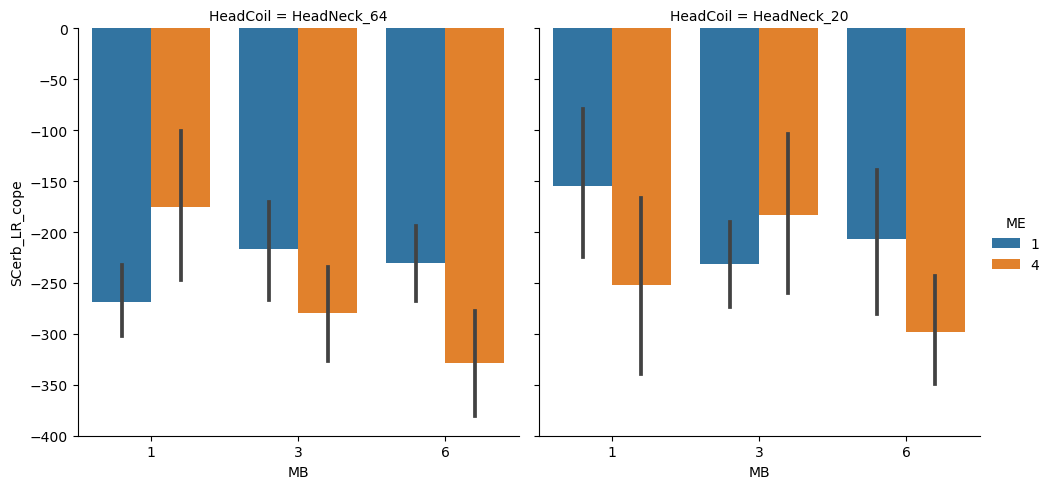

In [16]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('SCerb_LR_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('SCerb_LR_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('SCerb_LR_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='SCerb_LR_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_zstat.svg")
plt.show()

print("Results for Cope")
res=smf.mixedlm('SCerb_LR_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='SCerb_LR_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])

plt.savefig("../derivatives/figures/assets/sCerb_LR-act_cope.svg")
plt.show()

# print("Results for VarCope")
# res=smf.mixedlm('SCerb_LR_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='SCerb_LR_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])

#plt.savefig("../derivatives/figures/assets/sCerb_LR-act_varcope.svg")
#plt.show()

# vmPFC

In [17]:
masker= NiftiMasker(mask_img=pfc_mask)
                   
copes=[]
zstats=[]
varcopes=[]
for index,row in tqdm(subs.iterrows(),total=subs.shape[0]):
    sub=row['sub']
    aqc=row['acq']
    cope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/cope13.nii.gz'%(sub,aqc)
    zstat='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/tstat13.nii.gz'%(sub,aqc)
    varcope='../derivatives/fsl/%s/L1_task-sharedreward_model-1_type-act_acq-%s_sm-4.feat/stats/varcope13.nii.gz'%(sub,aqc)
    
    if os.path.exists(cope):
        #Extracting VS Reward cope,zstat, and varcope
        x=masker.fit_transform(cope)
        copes.append(np.mean(x.flatten()))

        x=masker.fit_transform(zstat)
        zstats.append(np.mean(x.flatten()))

        x=masker.fit_transform(varcope)
        varcopes.append(np.mean(x.flatten()))
    else:
        copes.append(np.nan)
        zstats.append(np.nan)
        varcopes.append(np.nan)
        
subs = subs.assign(pfc_act_cope=copes,
               pfc_act_zstats=zstats,
               pfc_act_varcope=varcopes)

100%|█████████████████████████████████████████████████████████████████████████| 190/190 [02:28<00:00,  1.28it/s]


# Display vmPFC

HeadNeck_64
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: pfc_act_zstats
No. Observations: 114     Method:             REML          
No. Groups:       19      Scale:              0.3627        
Min. group size:  6       Log-Likelihood:     -112.0316     
Max. group size:  6       Converged:          Yes           
Mean group size:  6.0                                       
--------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
--------------------------------------------------------------
Intercept   0.002      0.209   0.010   0.992   -0.407    0.412
MB          0.065      0.053   1.225   0.221   -0.039    0.170
ME          0.006      0.072   0.078   0.938   -0.135    0.146
MB:ME       0.012      0.018   0.639   0.523   -0.024    0.048
Group Var   0.000      0.058                                  
============================================================

"""

beta


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: pfc_act_cope
No. Observations: 114     Method:             REML        
No. Groups:       19      Scale:              31148.6784  
Min. group size:  6       Log-Likelihood:     -736.8660   
Max. group size:  6       Converged:          Yes         
Mean group size:  6.0                                     
----------------------------------------------------------
              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept     41.577   61.226  0.679 0.497 -78.423 161.577
MB             5.648   15.636  0.361 0.718 -24.997  36.293
ME           -11.278   21.000 -0.537 0.591 -52.438  29.881
MB:ME          4.515    5.363  0.842 0.400  -5.996  15.026
Group Var      0.059                                      
==========================================================

"""

HeadNeck_20
z-stat


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:            MixedLM Dependent Variable: pfc_act_zstats
No. Observations: 69      Method:             REML          
No. Groups:       12      Scale:              0.3288        
Min. group size:  5       Log-Likelihood:     -70.0397      
Max. group size:  6       Converged:          No            
Mean group size:  5.8                                       
-------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept     -0.105     0.266  -0.396  0.692  -0.627   0.416
MB             0.062     0.065   0.943  0.346  -0.066   0.189
ME             0.114     0.088   1.300  0.194  -0.058   0.286
MB:ME         -0.018     0.022  -0.802  0.423  -0.062   0.026
Group Var      0.046     0.101                               
============================================================

"""

beta


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:            MixedLM Dependent Variable: pfc_act_cope
No. Observations: 69      Method:             REML        
No. Groups:       12      Scale:              40108.5408  
Min. group size:  5       Log-Likelihood:     -450.3785   
Max. group size:  6       Converged:          Yes         
Mean group size:  5.8                                     
----------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------
Intercept   -24.196   92.634 -0.261 0.794 -205.755 157.363
MB           18.746   22.791  0.823 0.411  -25.922  63.415
ME           43.764   30.689  1.426 0.154  -16.386 103.914
MB:ME        -7.966    7.839 -1.016 0.310  -23.330   7.398
Group Var  4970.641   27.381                              
==========================================================

"""

Results for Zstatistics


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
========================================================================
Model:                MixedLM     Dependent Variable:     pfc_act_zstats
No. Observations:     183         Method:                 REML          
No. Groups:           31          Scale:                  0.3642        
Min. group size:      5           Log-Likelihood:         -182.3880     
Max. group size:      6           Converged:              Yes           
Mean group size:      5.9                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.110    0.272 -0.405 0.685 -0.643  0.422
HeadCoil[T.HeadNeck_64]        0.112    0.343  0.327 0.744 -0.560  0.784
MB                             0.063    0.069  0.917 0.359 -0.072  0.197
MB:HeadCoil[T.HeadNeck_64]     0.002    0.087  0.028 0.977 -0.168  0.173
ME                             0.114    0.092  1.240 0.215 -0.066  0.295
ME:HeadCoil[T.HeadNeck_64]    -0.109    0.117 -0.931 0.352 -0.338  0.120
MB:ME                         -0.019    0.024 -0.784 0.433 -0.065  0.028
MB:ME:HeadCoil[T.HeadNeck_64]  0.030    0.030  1.011 0.312 -0.028  0.089
Group Var                      0.000    0.030                           
========================================================================

"""

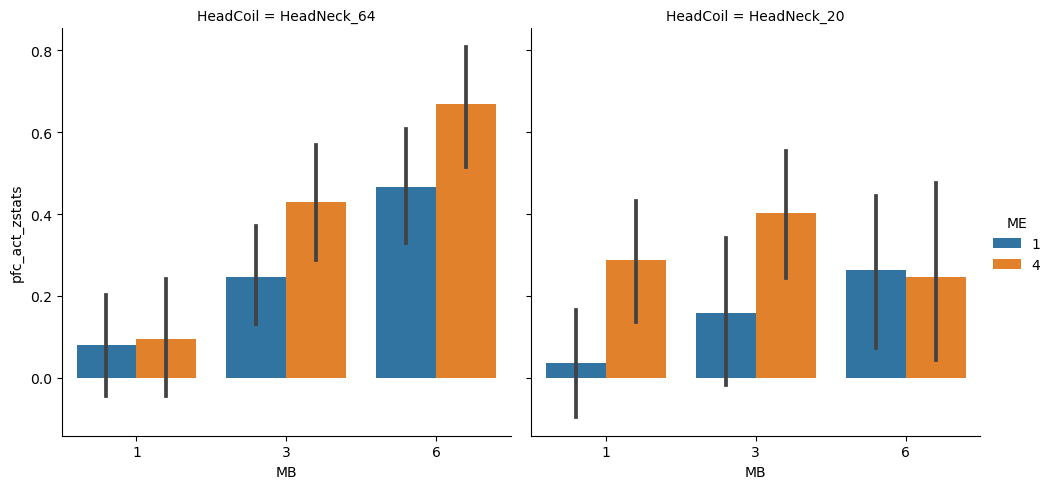

Results for Cope


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                  MixedLM       Dependent Variable:       pfc_act_cope
No. Observations:       183           Method:                   REML        
No. Groups:             31            Scale:                    36290.0329  
Min. group size:        5             Log-Likelihood:           -1189.4449  
Max. group size:        6             Converged:                Yes         
Mean group size:        5.9                                                 
----------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------------
Intercept                     -26.918   85.770 -0.314 0.754 -195.024 141.187
HeadCoil[T.HeadNeck_64]        68.495  108.276  0.633 0.527 -143.723 280.712
MB                             19.326   21.650  0.893 0.372  -23.107  61.758
MB:HeadCoil[T.HeadNeck_64]    -13.678   27.450 -0.498 0.618  -67.480  40.124
ME                             44.167   29.145  1.515 0.130  -12.957 101.290
ME:HeadCoil[T.HeadNeck_64]    -55.445   36.922 -1.502 0.133 -127.811  16.921
MB:ME                          -8.095    7.445 -1.087 0.277  -22.687   6.498
MB:ME:HeadCoil[T.HeadNeck_64]  12.610    9.431  1.337 0.181   -5.875  31.094
Group Var                       0.006    9.339                              
============================================================================

"""

<Figure size 640x480 with 0 Axes>

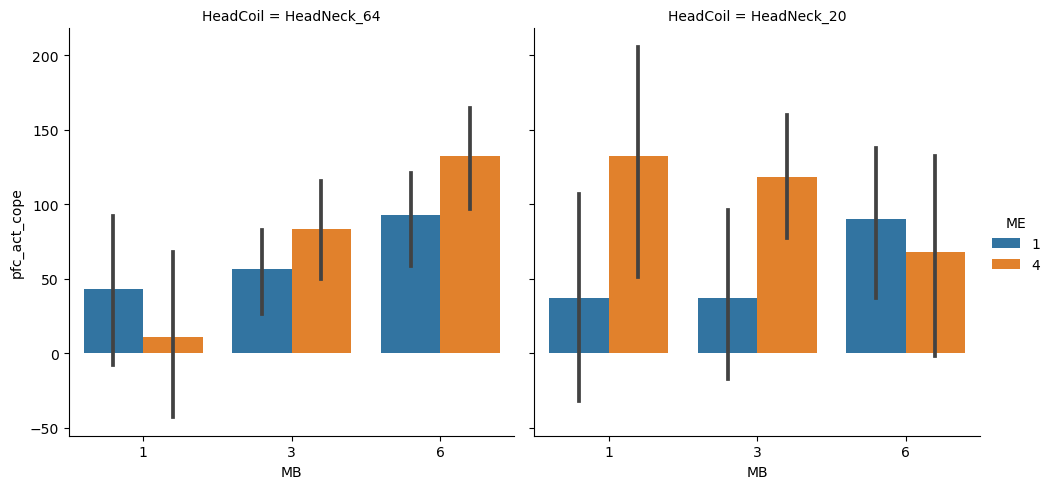

<Figure size 640x480 with 0 Axes>

In [18]:
import statsmodels.formula.api as smf
plt_df=subs[subs['L1act']]

for HC in plt_df['HeadCoil'].unique():
    mod_df = plt_df[plt_df['HeadCoil'] == HC]
    print(HC)
    print("z-stat")
    res=smf.mixedlm('pfc_act_zstats ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    print("beta")
    res=smf.mixedlm('pfc_act_cope ~ MB * ME',data=mod_df,groups=mod_df['sub']).fit()
    display(res.summary())
    
print("Results for Zstatistics")
res=smf.mixedlm('pfc_act_zstats ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_act_zstats',hue='ME',data=plt_df,kind='bar',order=[1,3,6],col='HeadCoil',ci=68)

plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_zstat.svg")

print("Results for Cope")
res=smf.mixedlm('pfc_act_cope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
display(res.summary())
sns.catplot(x='MB',y='pfc_act_cope',hue='ME',col='HeadCoil',ci=68,
            data=plt_df,kind='bar',order=[1,3,6])
plt.show()
plt.savefig("../derivatives/figures/assets/pfc_act-act_cope.svg")


# print("Results for VarCope")
# res=smf.mixedlm('pfc_act_varcope ~ MB * ME * HeadCoil',data=plt_df,groups=plt_df['sub']).fit()
# display(res.summary())
# sns.catplot(x='MB',y='pfc_act_varcope',hue='ME',col='HeadCoil',
#             data=plt_df,kind='bar',order=[1,3,6])
#plt.show()
#plt.savefig("../derivatives/figures/assets/pfc_act-act_varcope.svg")